In [1]:
%load_ext autoreload
%load_ext line_profiler
%autoreload 2

import numpy as np
from mpl_toolkits import mplot3d
import matplotlib
import matplotlib.pyplot as plt
import scipy.optimize as optimize
import Estimate
from EconModel import cpptools

from LimitedCommitmentModel import LimitedCommitmentModelClass

# plot style
linestyles = ['-','--','-.',':',':']
markers = ['o','s','D','*','P']
linewidth = 2
font_size = 17
font = {'size':font_size}
matplotlib.rc('font', **font)


plt.rcParams.update({'figure.max_open_warning': 0,'text.usetex': False})
path = 'output/'

SAVE = False

# c++ settings

do_compile = True
threads = 20

#cpptools.setup_nlopt(folder='cppfuncs/', do_print = True) #install nlopt
# problem: Mange perioder, værdien af HK i første periode er meget lavt, hvis vi ikke har HK, måske ændre til type? Type med højt return og type med lavt return

# Solve the model

In [2]:

specs = {}
T = 30
#T = 10
#specs.update({f'model_FC_NO_HK_T{T}_sHK{sigma_HK}_initHK{sigma_HK_init}_SL{sigma_love}':{'latexname':'limited', 'par':{ 'T':T, 'sigma_K':sigma_HK, 'sigma_K_init': sigma_HK_init, 'sigma_love': sigma_love, 'do_HK': False, 'threads':threads,'bargaining':0}}})
#specs.update({f'model_LC_NO_HK_T{T}_sHK{sigma_HK}_initHK{sigma_HK_init}_SL{sigma_love}':{'latexname':'limited', 'par':{ 'T':T, 'sigma_K':sigma_HK, 'sigma_K_init': sigma_HK_init, 'sigma_love': sigma_love, 'do_HK': False, 'threads':threads,'bargaining':1}}})
#specs.update({f'model_NC_NO_HK_T{T}_sHK{sigma_HK}_initHK{sigma_HK_init}_SL{sigma_love}':{'latexname':'limited', 'par':{ 'T':T, 'sigma_K':sigma_HK, 'sigma_K_init': sigma_HK_init, 'sigma_love': sigma_love, 'do_HK': False, 'threads':threads,'bargaining':2}}})

specs.update({f'model_LC':{'latexname':'limited', 'par':{ 'T':T, 'do_HK': False, 'threads':threads,'bargaining':2}}})
#specs.update({f'model_NC_nocompl':{'latexname':'limited', 'par':{ 'T':T,  'gamma2_w': 0.0, 'gamma2_m': 0.0 ,  'num_K': 20, 'do_HK': False, 'threads':threads,'bargaining':2}}})

#specs.update({f'model_NC_maxK':{'latexname':'limited', 'par':{ 'T':T,  'gamma2_w': 0.0, 'gamma2_m': 0.0, 'max_K':3.0 , 'do_HK': False, 'threads':threads,'bargaining':2}}})
#specs.update({f'model_NC_noK':{'latexname':'limited', 'par':{ 'T':T,   'gamma2_w': 0.0, 'gamma2_m': 0.0,'num_K': 40  ,'do_HK': False, 'threads':threads,'bargaining':2}}})
#specs.update({f'model_NC_sigmaK':{'latexname':'limited', 'par':{ 'T':T,  'gamma2_w': 0.0, 'gamma2_m': 0.0, 'sigma_K': 0.01  ,'do_HK': False, 'threads':threads,'bargaining':2}}})
#specs.update({f'model_NC_maxA':{'latexname':'limited', 'par':{ 'T':T,   'gamma2_w': 0.0, 'gamma2_m': 0.0, 'max_A': 40.0 , 'do_HK': False, 'threads':threads,'bargaining':2}}})
#specs.update({f'model_NC_noA':{'latexname':'limited', 'par':{ 'T':T,  'gamma2_w': 0.0,  'gamma2_m': 0.0, 'num_A': 100 , 'do_HK': False, 'threads':threads,'bargaining':2}}})
#specs.update({f'model_NC_doHK':{'latexname':'limited', 'par':{ 'T':T, 'gamma2_w': 0.0, 'gamma2_m': 0.0 , 'sigma_K': 0.01  , 'do_HK': True, 'threads':threads,'bargaining':2}}})
#specs.update({f'model_LC':{'latexname':'limited', 'par':{ 'T':T,  'do_HK':False , 'threads':threads,'bargaining':1}}})
#specs.update({f'model_LC_doHK':{'latexname':'limited', 'par':{ 'T':T,  'do_HK':True , 'threads':threads,'bargaining':1}}})
#specs.update({f'model_FC':{'latexname':'limited', 'par':{ 'T':T,  'do_HK': False, 'threads':threads,'bargaining':0}}})
#specs.update({f'model_FC_doHK':{'latexname':'limited', 'par':{ 'T':T,  'do_HK': True, 'threads':threads,'bargaining':0}}})
print(specs)



# solve different models
models = {}
for m,(name,spec) in enumerate(specs.items()):
    print(f'{name} loading...',end='')
    
    # setup model
    models[name] = LimitedCommitmentModelClass(name=name,par=spec['par'])
    models[name].spec = spec

    compile_now = True if do_compile & (m==0) else False
    models[name].link_to_cpp(force_compile=compile_now)
    
    print(' solving...')
    %time models[name].solve() 
    
    #Save the data 
    T = models[name].par.T
    print(' saving...')
    models[name].sim.init_love[:] = 0.0
    np.random.seed(models[name].par.seed)
    data1 = Estimate.create_data_new(models[name],start_p = 1, end_p = T-1, to_xl = True, name_xl = name)
    print(f'Couple {np.mean(models[name].sim.couple,0)}')
    print(f'HKw {np.mean(models[name].sim.Kw,0)}')
    print(f'HKm {np.mean(models[name].sim.Km,0)}')
    print(f'Laborw {np.mean(models[name].sim.labor_w,0)}')
    print(f'Laborm {np.mean(models[name].sim.labor_m,0)}')
    print(f'Asset {np.nanmean(models[name].sim.A,0)}')



#model = models['model FC, NO_HK ']
#model.sim.init_love[:] =0.2
##model.simulate()
#print('HK')*
#print(f'Couple {np.mean(model.sim.couple,0)}')

#print(f'Laborw {np.mean(model.sim.labor_w,0)}')
#print(f'Laborm {np.mean(model.sim.labor_m,0)}')
#print(f'Consumption W {np.mean(model.sim.cons_w,0)}')
#print(f'Consumption M {np.mean(model.sim.cons_m,0)}')
#print(f'Asset {np.nanmean(model.sim.A,0)}')
#print(f'HKw {np.mean(model.sim.Kw,0)}')
#print(f'HKm {np.mean(model.sim.Km,0)}')
#temp = model.sim.power
#I = model.sim.couple<1
#nan = np.zeros(I.shape)
#nan[I] = np.nan
#temp = np.nanmean(temp + nan,axis=0)
#print(f'Power {temp}')


{'model_LC': {'latexname': 'limited', 'par': {'T': 3, 'do_HK': False, 'threads': 20, 'bargaining': 2}}}
model_LC loading... solving...
CPU times: total: 28min 48s
Wall time: 2min 33s
 saving...
Couple [1.     0.9856 0.8674]
HKw [0.10000441 0.58653054 0.61003289]
HKm [0.09883281 0.58562567 0.61223065]
Laborw [0.88599422 0.84775811 0.80308845]
Laborm [0.87647164 0.85092365 0.80080247]
Asset [0.00023733 0.09309516 0.0421132 ]


In [3]:

model = models['model_LC']

sol = models['model_LC'].sol
par = models['model_LC'].par
sim =  models['model_LC'].sim

print(f'HKw max {np.max(model.sim.Kw,0)}')
print(f'HKm max {np.max(model.sim.Km,0)}')


print(f'HKw min {np.min(model.sim.Kw,0)}')
print(f'HKm min {np.min(model.sim.Km,0)}')
#print(sim.draw_Kw_temp)
print(sim.draw_Kw)

print(f'A max {np.nanmax(model.sim.A,0)}')
print(f'A min {np.nanmin(model.sim.A,0)}')
print(sim.draw_Kw_temp)

print(f'Love max {np.nanmax(model.sim.love,0)}')
print(f'Love mean {np.nanmean(model.sim.love,0)}')
print(f'Love min {np.nanmin(model.sim.love ,0)}')




print(f'laborW max {np.nanmax(model.sim.labor_w,0)}')
print(f'laborW mean {np.nanmean(model.sim.labor_w,0)}')
print(f'LaborW min {np.nanmin(model.sim.labor_w,0)}')

print(par.grid_A)

HKw max [0.19998517 0.99181747 0.98139574]
HKm max [0.19999275 0.9639833  0.9733073 ]
HKw min [0.00027716 0.19470635 0.27195969]
HKm min [2.82174588e-05 1.91098244e-01 2.47372658e-01]
[[-0.13167789  0.06707716 -0.11781539]
 [-0.15112961  0.03541352  0.11705184]
 [-0.1032158   0.09454621 -0.17079805]
 ...
 [ 0.10203611  0.13389576  0.12599742]
 [-0.02010464 -0.09638403 -0.02663155]
 [-0.01773689 -0.04381397  0.12049741]]
A max [0.02916668 0.69719425 0.74044733]
A min [0. 0. 0.]
[[-0.13167789  0.06707716 -0.11781539]
 [-0.15112961  0.03541352  0.11705184]
 [-0.1032158   0.09454621 -0.17079805]
 ...
 [ 0.10203611  0.13389576  0.12599742]
 [-0.02010464 -0.09638403 -0.02663155]
 [-0.01773689 -0.04381397  0.12049741]]
Love max [0.         0.12672663 0.16223656]
Love mean [0.         0.00011909 0.00107429]
Love min [ 0.         -0.10408601 -0.18326745]
laborW max [1. 1. 1.]
laborW mean [0.88599422 0.84775811 0.80308845]
LaborW min [0.6151582  0.51426395 0.25841598]
[ 0.          0.05830904  0

[-5.72952474 -5.68219201 -5.63460798 -5.58678876 -5.53875193 -5.49051683
 -5.44210453 -5.39353796 -5.3444627  -5.29444726 -5.24336698 -5.19137613
 -5.13846519 -5.08442108 -5.02922816 -4.97302381 -4.91575415 -4.85723109
 -4.79740745 -4.73635887 -4.67410357 -4.61056217 -4.54559103 -4.47914516
 -4.41118728 -4.34172564 -4.27073567 -4.19815438 -4.12391546 -4.04794929
 -3.97018235 -3.89053826 -3.80893593 -3.72529247 -3.63952041 -3.55152874
 -3.46122227 -3.36849966 -3.27310329 -3.17454799 -3.07245448 -2.96700925
 -2.85732704 -2.74190897 -2.62092237 -2.49097971 -2.35024842 -2.19345596
 -2.00916926 -1.76788537]
[-7.61152474 -7.56419201 -7.51660798 -7.46878876 -7.42075193 -7.37251683
 -7.32410453 -7.27553796 -7.2264627  -7.17644726 -7.125367   -7.07337609
 -7.02046523 -6.96642108 -6.91122816 -6.85502374 -6.79775415 -6.73923109
 -6.67940747 -6.61835865 -6.5561036  -6.49256217 -6.42759103 -6.36114591
 -6.29318728 -6.22372564 -6.15273567 -6.08015441 -6.0059155  -5.92994929
 -5.85218236 -5.77253814 

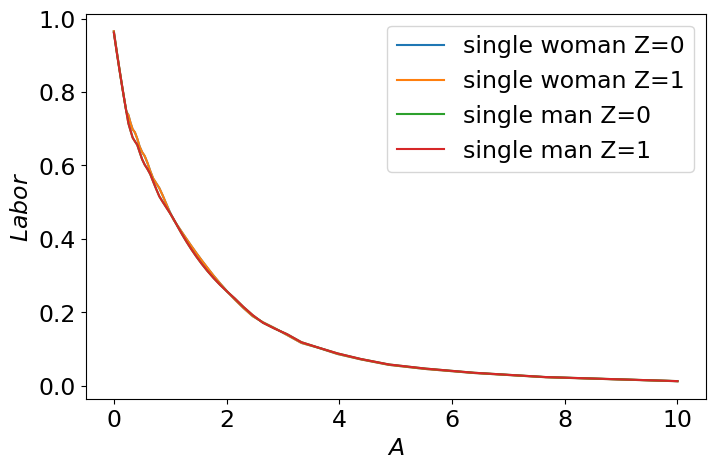

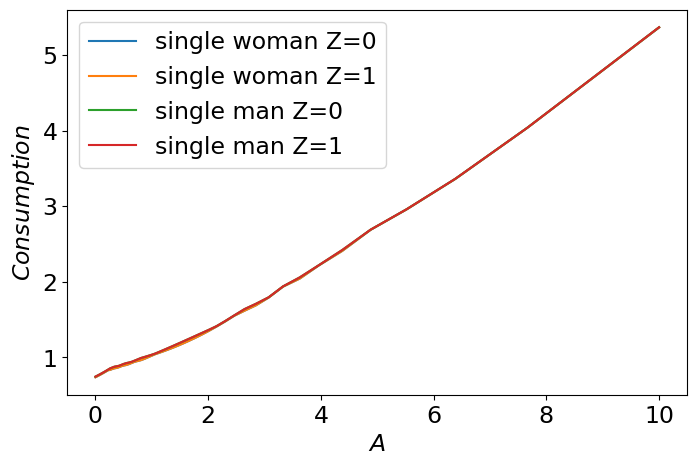

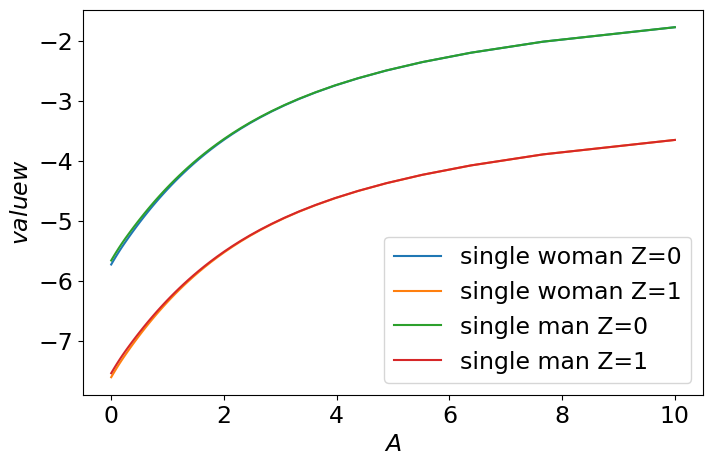

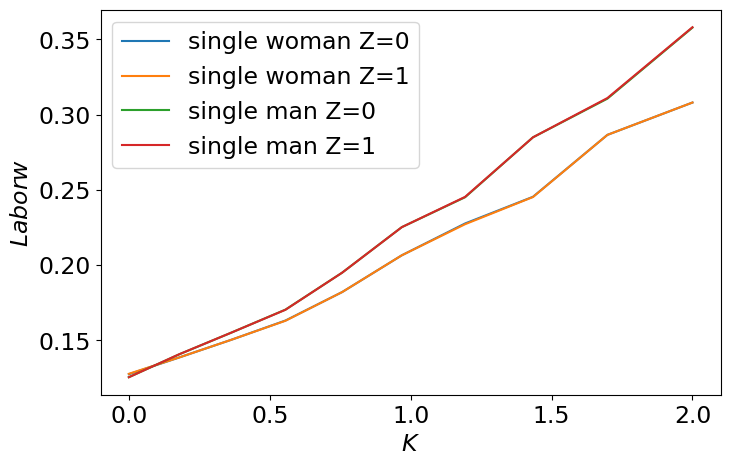

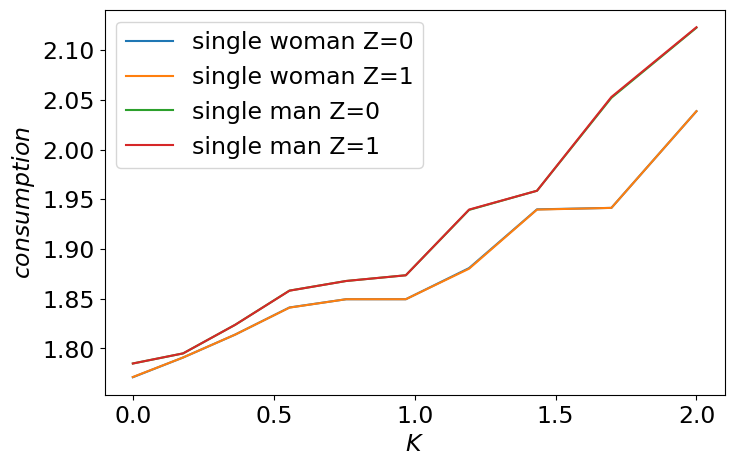

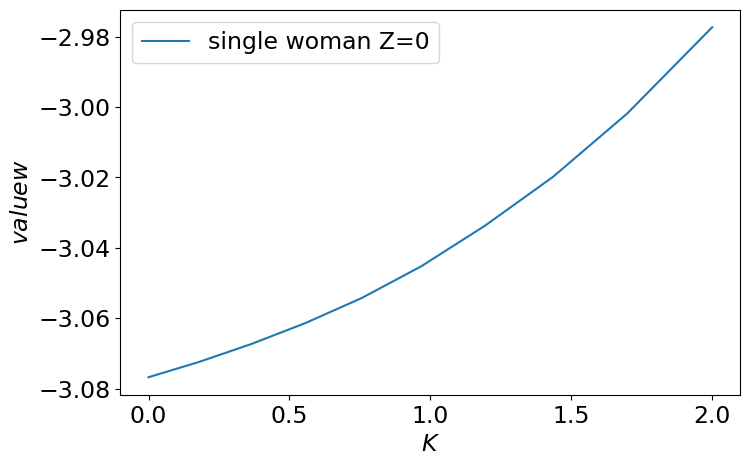

In [4]:
#SINGLE TEST
i_A = 40
i_Z = 0
i_HK = 1
t = 1
#i_A = 1


#sol = models['model 2'].sol
#par = models['model 2'].par


#print(sol.labor_w_couple[t,i_P,i_L,:,i_HKw,i_HKm])

#print(sol.labor_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm])





sol = models['model_LC'].sol
par = models['model_LC'].par


print(sol.Vw_single[t,0,:,i_HK])
print(sol.Vw_single[t,1,:,i_HK])


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_Aw,sol.labor_w_single[t,0,:,i_HK], label = 'single woman Z=0')
ax.plot(par.grid_Aw,sol.labor_w_single[t,1,:,i_HK], label = 'single woman Z=1')
ax.plot(par.grid_Am,sol.labor_m_single[t,0,:,i_HK], label = 'single man Z=0')
ax.plot(par.grid_Am,sol.labor_m_single[t,1,:,i_HK], label = 'single man Z=1')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Labor$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_Aw,sol.cons_w_single[t,0,:,i_HK], label = 'single woman Z=0')
ax.plot(par.grid_Aw,sol.cons_w_single[t,1,:,i_HK], label = 'single woman Z=1')
ax.plot(par.grid_Am,sol.cons_m_single[t,0,:,i_HK], label = 'single man Z=0')
ax.plot(par.grid_Am,sol.cons_m_single[t,1,:,i_HK], label = 'single man Z=1')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Consumption$")
plt.legend()
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_Aw,sol.Vw_single[t,0,:,i_HK], label = 'single woman Z=0')
ax.plot(par.grid_Aw,sol.Vw_single[t,1,:,i_HK], label = 'single woman Z=1')
ax.plot(par.grid_Am,sol.Vm_single[t,0,:,i_HK], label = 'single man Z=0')
ax.plot(par.grid_Am,sol.Vm_single[t,1,:,i_HK], label = 'single man Z=1')                           
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$valuew$")
plt.legend()
plt.show()





fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_K,sol.labor_w_single[t,0,i_A,:], label = 'single woman Z=0')
ax.plot(par.grid_K,sol.labor_w_single[t,1,i_A,:], label = 'single woman Z=1')
ax.plot(par.grid_K,sol.labor_m_single[t,0,i_A,:], label = 'single man Z=0')
ax.plot(par.grid_K,sol.labor_m_single[t,1,i_A,:], label = 'single man Z=1')                      
ax.set_xlabel(f"$K$")
ax.set_ylabel(f"$Laborw$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_K,sol.cons_w_single[t,0,i_A,:], label = 'single woman Z=0')
ax.plot(par.grid_K,sol.cons_w_single[t,1,i_A,:], label = 'single woman Z=1')
ax.plot(par.grid_K,sol.cons_m_single[t,0,i_A,:], label = 'single man Z=0')
ax.plot(par.grid_K,sol.cons_m_single[t,1,i_A,:], label = 'single man Z=1')                      
ax.set_xlabel(f"$K$")
ax.set_ylabel(f"$consumption$")
plt.legend()
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_K,sol.Vw_single[t,0,i_A,:], label = 'single woman Z=0')
#ax.plot(par.grid_K,sol.Vw_single[t,1,i_A,:], label = 'single woman Z=1')
#ax.plot(par.grid_K,sol.Vm_single[t,0,i_A,:], label = 'single man Z=0')
#ax.plot(par.grid_K,sol.Vm_single[t,1,i_A,:], label = 'single man Z=1')                           
ax.set_xlabel(f"$K$")
ax.set_ylabel(f"$valuew$")
plt.legend()
plt.show()



In [5]:
#SINGLE TEST
i_A = 20
i_Z = 0
i_HK = 1
t = 1

#sol = models['model 2'].sol
#par = models['model 2'].par


#print(sol.labor_w_couple[t,i_P,i_L,:,i_HKw,i_HKm])

#print(sol.labor_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm])





sol = models['model_NC'].sol
par = models['model_NC'].par

#par2 = models['model_NC_maxK'].par
#sol2 = models['model_NC_maxK'].sol

#sol3 = models['model_NC_noK'].sol
#par3 = models['model_NC_noK'].par

#sol4 = models['model_NC_sigmaK'].sol
#par4 = models['model_NC_sigmaK'].par

#sol5 = models['model_NC_maxA'].sol
#par5 = models['model_NC_maxA'].par

#sol6 = models['model_NC_noA'].sol
#par6 = models['model_NC_noA'].par


sol7 = models['model_NC_nocompl'].sol
par7 = models['model_NC_nocompl'].par


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_K,sol.labor_w_single[t,i_Z,i_A,:], label = ' normal ')
#ax.plot(par2.grid_K,sol2.labor_w_single[t,i_Z,i_A,:], label = 'max_K')
#ax.plot(par3.grid_K,sol3.labor_w_single[t,i_Z,i_A,:], label = 'no K')
#ax.plot(par4.grid_K,sol4.labor_w_single[t,i_Z,i_A,:], label = 'sigma K')   
#ax.plot(par5.grid_K,sol5.labor_w_single[t,i_Z,i_AA,:], label = 'maxA')   
#ax.plot(par6.grid_K,sol6.labor_w_single[t,i_Z,i_AA2,:], label = 'NoA')         
ax.plot(par7.grid_K,sol7.labor_w_single[t,i_Z,i_A,:], label = 'No Compl')                     
ax.set_xlabel(f"$K$")
ax.set_ylabel(f"$Laborw$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_K,sol.cons_w_single[t,i_Z,i_A,:], label = ' normal ')
#ax.plot(par2.grid_K,sol2.cons_w_single[t,i_Z,i_A,:], label = 'max_K')
#ax.plot(par3.grid_K,sol3.cons_w_single[t,i_Z,i_A,:], label = 'no K')
#ax.plot(par4.grid_K,sol4.cons_w_single[t,i_Z,i_A,:], label = 'sigma K')    
#ax.plot(par5.grid_K,sol5.cons_w_single[t,i_Z,i_AA,:], label = 'maxA')     
#ax.plot(par6.grid_K,sol6.cons_w_single[t,i_Z,i_AA2,:], label = 'NoA')  
ax.plot(par7.grid_K,sol7.cons_w_single[t,i_Z,i_A,:], label = 'No Compl')                             
ax.set_xlabel(f"$K$")
ax.set_ylabel(f"$Consw$")
plt.legend()
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_K,sol.labor_m_single[t,i_Z,i_A,:], label = ' normal ')
#ax.plot(par2.grid_K,sol2.labor_m_single[t,i_Z,i_A,:], label = 'max_K')
#ax.plot(par3.grid_K,sol3.labor_m_single[t,i_Z,i_A,:], label = 'no K')
#ax.plot(par4.grid_K,sol4.labor_m_single[t,i_Z,i_A,:], label = 'sigma K')    
#ax.plot(par5.grid_K,sol5.labor_m_single[t,i_Z,i_AA,:], label = 'maxA')     
#ax.plot(par6.grid_K,sol6.labor_m_single[t,i_Z,i_AA2,:], label = 'NoA')       
ax.plot(par7.grid_K,sol7.labor_m_single[t,i_Z,i_A,:], label = 'No Compl')                        
ax.set_xlabel(f"$K$")
ax.set_ylabel(f"$Laborm$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_K,sol.cons_m_single[t,i_Z,i_A,:], label = ' normal ')
#ax.plot(par2.grid_K,sol2.cons_m_single[t,i_Z,i_A,:], label = 'max_K')
#ax.plot(par3.grid_K,sol3.cons_m_single[t,i_Z,i_A,:], label = 'no K')
#ax.plot(par4.grid_K,sol4.cons_m_single[t,i_Z,i_A,:], label = 'sigma K')    
#ax.plot(par5.grid_K,sol5.cons_m_single[t,i_Z,i_AA,:], label = 'maxA')     
#ax.plot(par6.grid_K,sol6.cons_m_single[t,i_Z,i_AA2,:], label = 'NoA')  
ax.plot(par7.grid_K,sol7.cons_m_single[t,i_Z,i_A,:], label = 'No Compl')                             
ax.set_xlabel(f"$K$")
ax.set_ylabel(f"$Consm$")
plt.legend()
plt.show()

KeyError: 'model_NC'

[-65.75140128 -65.75140128 -65.23779894 -62.55610705 -59.16099495
 -55.55536134 -51.89179248 -48.22591109 -44.51349029 -40.96186825]
[-66.52683455 -66.30930653 -65.36268441 -62.59655108 -59.16900554
 -55.57218283 -51.97769628 -48.31293502 -44.68369453 -41.13207248]
-65.7514012842769


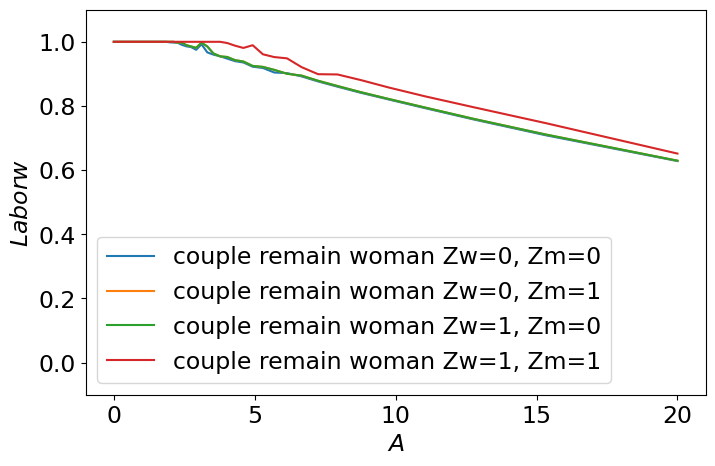

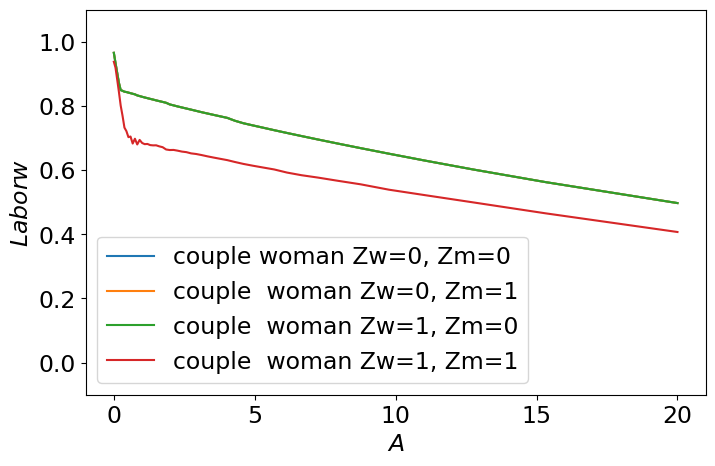

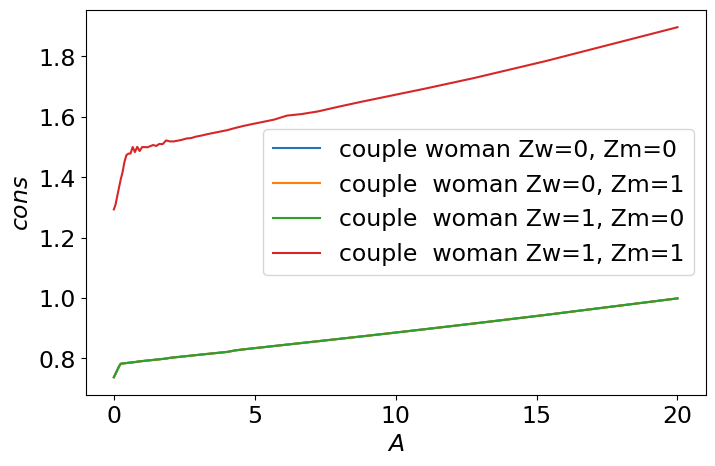

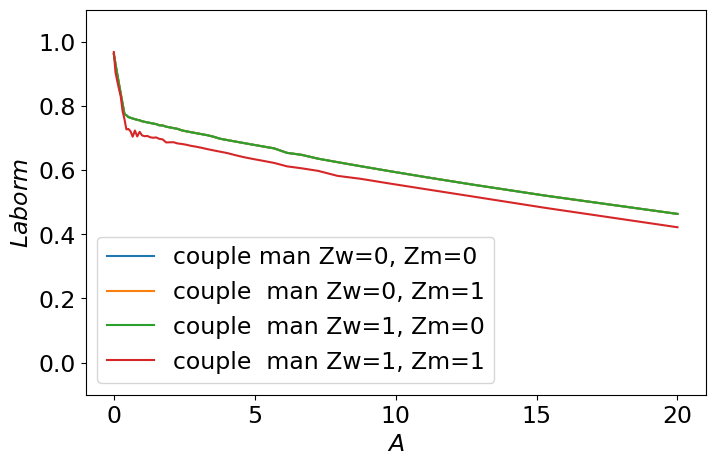

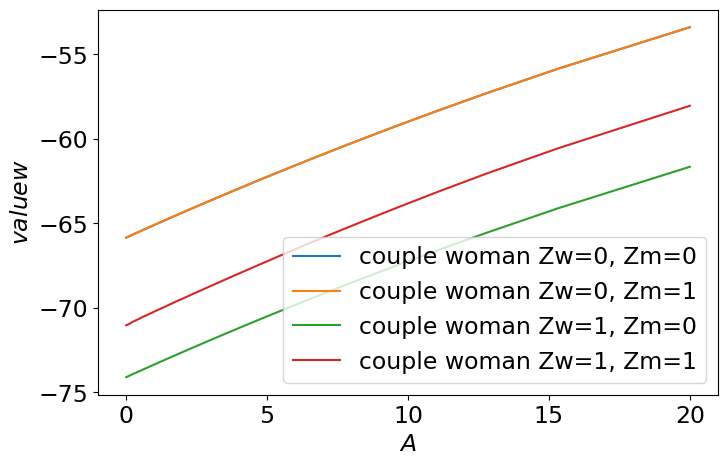

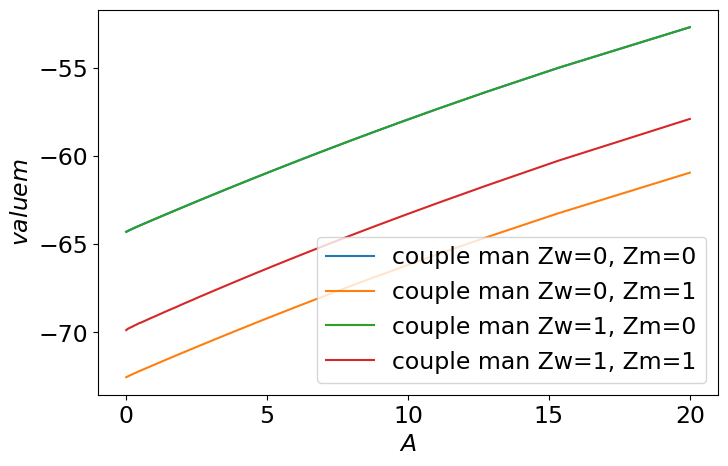

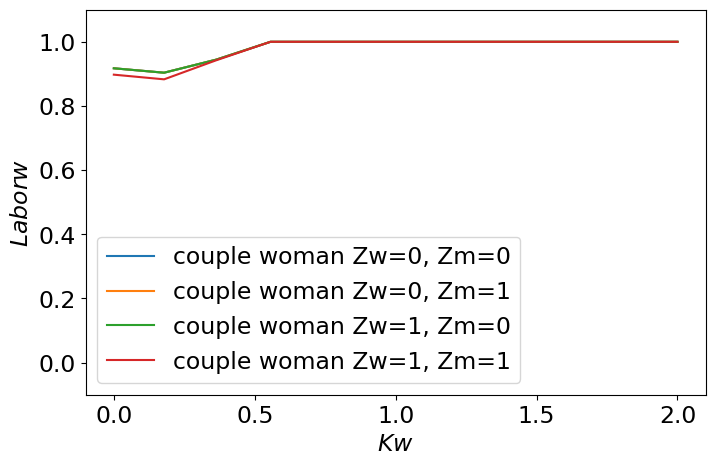

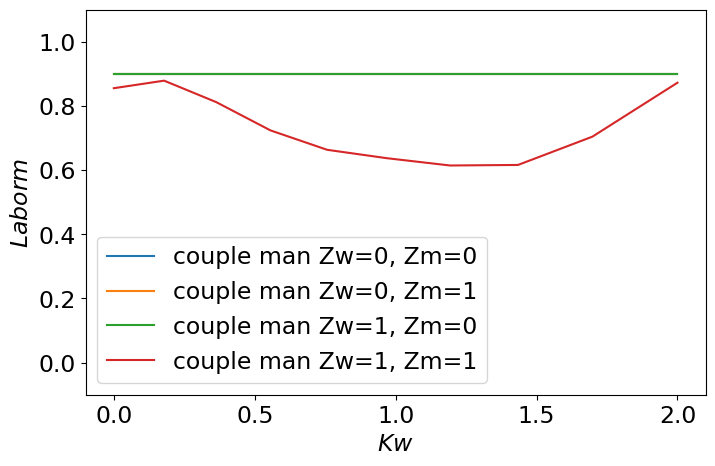

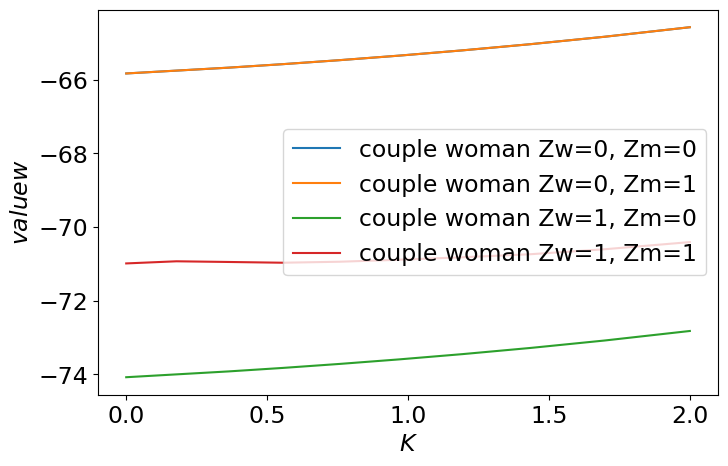

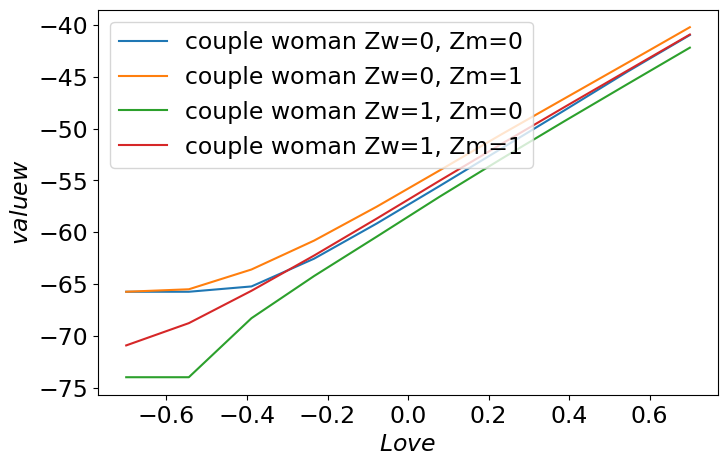

In [ ]:
#COUPLE TEST
i_P = 9
i_L = 0
i_A = 2
i_HKw = 1
i_HKm = 1
t = 1


#print(sol.labor_w_couple[t,i_P,i_L,:,i_HKw,i_HKm])

#print(sol.labor_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm])



#print(sol.labor_w_single[t,:,i_HKm])

sol = models['model_LC'].sol
par = models['model_LC'].par

print(sol.Vw_couple[t,0,0,i_P,:,i_A,i_HKw,i_HKm])

print(sol.Vw_remain_couple[t,0,0,i_P,:,i_A,i_HKw,i_HKm])

print(sol.Vw_single[t,0,i_A,i_HKw])



#TEST COUPLE!!
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.labor_w_remain_couple[t,0,0,i_P,i_L,:,i_HKw,i_HKm], label = 'couple remain woman Zw=0, Zm=0')
ax.plot(par.grid_A,sol.labor_w_remain_couple[t,0,1,i_P,i_L,:,i_HKw,i_HKm], label = 'couple remain woman Zw=0, Zm=1')
ax.plot(par.grid_A,sol.labor_w_remain_couple[t,1,0,i_P,i_L,:,i_HKw,i_HKm], label = 'couple remain woman Zw=1, Zm=0')
ax.plot(par.grid_A,sol.labor_w_remain_couple[t,1,1,i_P,i_L,:,i_HKw,i_HKm],label = 'couple remain woman Zw=1, Zm=1')                      
ax.set_xlabel(f"$A$")
ax.set_ylim(-0.1,1.1)
ax.set_ylabel(f"$Laborw$")
plt.legend()
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.labor_w_couple[t,0,0,i_P,i_L,:,i_HKw,i_HKm], label = 'couple woman Zw=0, Zm=0')
ax.plot(par.grid_A,sol.labor_w_couple[t,0,1,i_P,i_L,:,i_HKw,i_HKm], label = 'couple  woman Zw=0, Zm=1')
ax.plot(par.grid_A,sol.labor_w_couple[t,1,0,i_P,i_L,:,i_HKw,i_HKm], label = 'couple  woman Zw=1, Zm=0')
ax.plot(par.grid_A,sol.labor_w_couple[t,1,1,i_P,i_L,:,i_HKw,i_HKm],label = 'couple  woman Zw=1, Zm=1')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Laborw$")

ax.set_ylim(-0.1,1.1)
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.cons_w_couple[t,0,0,i_P,i_L,:,i_HKw,i_HKm], label = 'couple woman Zw=0, Zm=0')
ax.plot(par.grid_A,sol.cons_w_couple[t,0,1,i_P,i_L,:,i_HKw,i_HKm], label = 'couple  woman Zw=0, Zm=1')
ax.plot(par.grid_A,sol.cons_w_couple[t,1,0,i_P,i_L,:,i_HKw,i_HKm], label = 'couple  woman Zw=1, Zm=0')
ax.plot(par.grid_A,sol.cons_w_couple[t,1,1,i_P,i_L,:,i_HKw,i_HKm],label = 'couple  woman Zw=1, Zm=1')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$cons$")
plt.legend()
plt.show()


#TEST COUPLE!!
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.labor_m_couple[t,0,0,i_P,i_L,:,i_HKw,i_HKm], label = 'couple man Zw=0, Zm=0')
ax.plot(par.grid_A,sol.labor_m_couple[t,0,1,i_P,i_L,:,i_HKw,i_HKm], label = 'couple  man Zw=0, Zm=1')
ax.plot(par.grid_A,sol.labor_m_couple[t,1,0,i_P,i_L,:,i_HKw,i_HKm], label = 'couple  man Zw=1, Zm=0')
ax.plot(par.grid_A,sol.labor_m_couple[t,1,1,i_P,i_L,:,i_HKw,i_HKm], label = 'couple  man Zw=1, Zm=1')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Laborm$")
ax.set_ylim(-0.1,1.1)
plt.legend()
plt.show()





fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.Vw_couple[t,0,0,i_P,i_L,:,i_HKw,i_HKm], label = 'couple woman Zw=0, Zm=0')
ax.plot(par.grid_A,sol.Vw_couple[t,0,1,i_P,i_L,:,i_HKw,i_HKm], label = 'couple woman Zw=0, Zm=1')
ax.plot(par.grid_A,sol.Vw_couple[t,1,0,i_P,i_L,:,i_HKw,i_HKm], label = 'couple woman Zw=1, Zm=0')
ax.plot(par.grid_A,sol.Vw_couple[t,1,1,i_P,i_L,:,i_HKw,i_HKm], label = 'couple woman Zw=1, Zm=1')                           
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$valuew$")
plt.legend()
plt.show()




fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.Vm_couple[t,0,0,i_P,i_L,:,i_HKw,i_HKm], label = 'couple man Zw=0, Zm=0')
ax.plot(par.grid_A,sol.Vm_couple[t,0,1,i_P,i_L,:,i_HKw,i_HKm], label = 'couple man Zw=0, Zm=1')
ax.plot(par.grid_A,sol.Vm_couple[t,1,0,i_P,i_L,:,i_HKw,i_HKm], label = 'couple man Zw=1, Zm=0')
ax.plot(par.grid_A,sol.Vm_couple[t,1,1,i_P,i_L,:,i_HKw,i_HKm], label = 'couple man Zw=1, Zm=1')                           
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$valuem$")
plt.legend()
plt.show()





fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_K,sol.labor_w_couple[t,0,0,i_P,i_L,i_A,:,i_HKm], label = 'couple woman Zw=0, Zm=0')
ax.plot(par.grid_K,sol.labor_w_couple[t,0,1,i_P,i_L,i_A,:,i_HKm], label = 'couple woman Zw=0, Zm=1')
ax.plot(par.grid_K,sol.labor_w_couple[t,1,0,i_P,i_L,i_A,:,i_HKm], label = 'couple woman Zw=1, Zm=0')
ax.plot(par.grid_K,sol.labor_w_couple[t,1,1,i_P,i_L,i_A,:,i_HKm], label = 'couple woman Zw=1, Zm=1')                      
ax.set_xlabel(f"$Kw$")
ax.set_ylim(-0.1,1.1)
ax.set_ylabel(f"$Laborw$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_K,sol.labor_m_couple[t,0,0,i_P,i_L,i_A,:,i_HKm], label = 'couple man Zw=0, Zm=0')
ax.plot(par.grid_K,sol.labor_m_couple[t,0,1,i_P,i_L,i_A,:,i_HKm], label = 'couple man Zw=0, Zm=1')
ax.plot(par.grid_K,sol.labor_m_couple[t,1,0,i_P,i_L,i_A,:,i_HKm], label = 'couple man Zw=1, Zm=0')
ax.plot(par.grid_K,sol.labor_m_couple[t,1,1,i_P,i_L,i_A,:,i_HKm], label = 'couple man Zw=1, Zm=1')                      
ax.set_xlabel(f"$Kw$")
ax.set_ylim(-0.1,1.1)
ax.set_ylabel(f"$Laborm$")
plt.legend()
plt.show()



fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_K,sol.Vw_couple[t,0,0,i_P,i_L,i_A,:,i_HKm], label = 'couple woman Zw=0, Zm=0')
ax.plot(par.grid_K,sol.Vw_couple[t,0,1,i_P,i_L,i_A,:,i_HKm], label = 'couple woman Zw=0, Zm=1')
ax.plot(par.grid_K,sol.Vw_couple[t,1,0,i_P,i_L,i_A,:,i_HKm], label = 'couple woman Zw=1, Zm=0')
ax.plot(par.grid_K,sol.Vw_couple[t,1,1,i_P,i_L,i_A,:,i_HKm], label = 'couple woman Zw=1, Zm=1')                           
ax.set_xlabel(f"$K$")
ax.set_ylabel(f"$valuew$")
plt.legend()
plt.show()




fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_love,sol.Vw_couple[t,0,0,i_P,:,i_A,i_HKw,i_HKm], label = 'couple woman Zw=0, Zm=0')
ax.plot(par.grid_love,sol.Vw_couple[t,0,1,i_P,:,i_A,i_HKw,i_HKm], label = 'couple woman Zw=0, Zm=1')
ax.plot(par.grid_love,sol.Vw_couple[t,1,0,i_P,:,i_A,i_HKw,i_HKm], label = 'couple woman Zw=1, Zm=0')
ax.plot(par.grid_love,sol.Vw_couple[t,1,1,i_P,:,i_A,i_HKw,i_HKm], label = 'couple woman Zw=1, Zm=1')                           
ax.set_xlabel(f"$Love$")
ax.set_ylabel(f"$valuew$")
plt.legend()
plt.show()









In [ ]:
stop

#model = models['model FC, NO_HK ']
#model.sim.init_love[:] =0.2
##model.simulate()
#print('HK')*
#print(f'Couple {np.mean(model.sim.couple,0)}')

#print(f'Laborw {np.mean(model.sim.labor_w,0)}')
#print(f'Laborm {np.mean(model.sim.labor_m,0)}')
#print(f'Consumption W {np.mean(model.sim.cons_w,0)}')
#print(f'Consumption M {np.mean(model.sim.cons_m,0)}')
#print(f'Asset {np.nanmean(model.sim.A,0)}')
#print(f'HKw {np.mean(model.sim.Kw,0)}')
#print(f'HKm {np.mean(model.sim.Km,0)}')
#temp = model.sim.power
#I = model.sim.couple<1
#nan = np.zeros(I.shape)
#nan[I] = np.nan
#temp = np.nanmean(temp + nan,axis=0)
#print(f'Power {temp}')


model = models[f'model_LC']
#model.sim.init_love[:] =0.1
#model.sim.init_A[:] = 6.0
#model.simulate()
print('NO hk')

i = 5
#note kvinden tjenner fx meget mere i en periode: 
    #højere barganing --> hun arbjeder mnindre , mand mere
    # højere indkomst --> hun og hendes mand arbjeder mindre. Dermed skal X5 påvirkes også her (INDKOMSTEFFEKT)
print(f'Person i, init init_distr {model.sim.init_distr[i]}')
print(f'Person i, init init_distrpowerlag {model.sim.init_distr_power_lag[i]}')
print(f'Person i, power {model.sim.power[i,:]}')
print(f'Person i, Zw {model.sim.Zw[i]}')
print(f'Person i, Zm {model.sim.Zm[i]}')
print(f'Person i, Kw {model.sim.Kw[i]}')
print(f'Person i, Km {model.sim.Km[i]}')
print(f'Person i, Laborw {model.sim.labor_w[i]}')
print(f'Person i, Laborm {model.sim.labor_m[i]}')
print(f'Person i, A {model.sim.A[i]}')
print(f'Person i, Aw {model.sim.Aw[i]}')
print(f'Person i, Am {model.sim.Am[i]}')
print(f'Person i, consw {model.sim.cons_w[i]}')
print(f'Couple {np.mean(model.sim.couple,0)}')

print(f'Laborw {np.mean(model.sim.labor_w,0)}')
print(f'Laborm {np.mean(model.sim.labor_m,0)}')
print(f'Consumption W {np.mean(model.sim.cons_w,0)}')
print(f'Consumption M {np.mean(model.sim.cons_m,0)}')
print(f'Asset {np.nanmean(model.sim.A,0)}')
print(f'Asset min {np.nanmin(model.sim.A,0)}')
print(f'Asset max {np.nanmax(model.sim.A,0)}')
print(f'Asset W {np.nanmean(model.sim.Aw,0)}')
print(f'Asset M {np.nanmean(model.sim.Am,0)}')
print(f'w {np.mean(model.sim.Zw,0)}')
print(f'Zm {np.mean(model.sim.Zm,0)}')
print(f'HKw {np.mean(model.sim.Kw,0)}')
print(f'HKm {np.mean(model.sim.Km,0)}')
print(f'HKw max {np.max(model.sim.Kw,0)}')
print(f'HKm max {np.max(model.sim.Km,0)}')
print(f'HKw min {np.min(model.sim.Kw,0)}')
print(f'HKm min {np.min(model.sim.Km,0)}')
print(f'Power mean {np.mean(model.sim.power,0)}')
print(f'Power min {np.min(model.sim.power,0)}')
print(f'Power max {np.max(model.sim.power,0)}')




NameError: name 'stop' is not defined

0.17005992887045385
0.40462567522381887
[0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
0.12050720705932783
1.5752877570614197
[0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.41312005 0.49270751]
power mean [0.5        0.5        0.5        0.4999989  0.49982842 0.49874748
 0.49567616 0.49032608 0.48164054 0.45893999]
power min [ 0.5         0.5         0.5         0.48304133  0.41603964  0.34852693
  0.33474968 -1.         -1.         -1.        ]
power max [0.5        0.5        0.5        0.5        0.5        0.5
 0.5        0.5        0.5        0.52638632]
Kw [1.99991622 1.99241943 2.90897843 3.76047495 4.55808104 4.9850127
 5.69764106 6.44182034 7.28328528 7.34640715]
[0. 0. 0. ... 0. 0. 0.]
[[8.95428705e-02 1.06618944e-03]
 [1.06618944e-03 8.88323720e-05]]
[[ 8.95428705e-02 -3.82167146e-06]
 [-3.82167146e-06  5.31870575e-05]]
[[ 6.31062361e-02 -2.94450541e-04]
 [-2.94450541e-04  8.88323720e-05]]
[0. 0. 1. ... 0. 0. 1.]


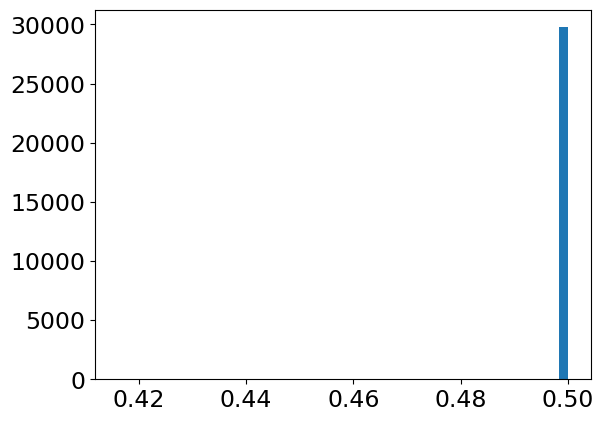

[[ 5.71333464e-06 -8.32234143e-06]
 [-8.32234143e-06  2.50007196e-01]]


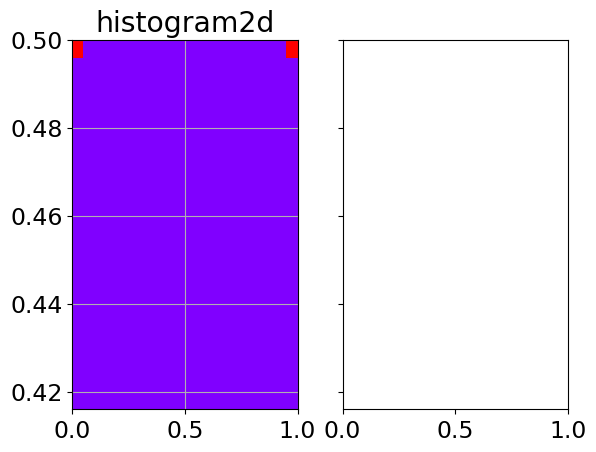

In [ ]:

i = 10
print(model.sim.init_Kw[i])
print(model.sim.init_Km[i])
print(model.sim.power[i,:])



i = 1
print(model.sim.init_Kw[i])
print(model.sim.init_Km[i])
print(model.sim.power[i,:])



t = 4
print(f'power mean {np.mean(model.sim.power,0)}')
print(f'power min {np.min(model.sim.power,0)}')
print(f'power max {np.max(model.sim.power,0)}')
print(f'Kw {np.max(model.sim.Kw,0)}')


I = model.sim.couple[:,t]<1.0
nan = np.zeros(I.shape)
nan[I] = np.nan
print(nan)

init_barg = model.sim.init_Kw > model.sim.init_Km
init_barg = init_barg+nan

sim_power= model.sim.power[:,t]
sim_power= sim_power+ nan



print(np.cov(model.sim.Kw[:,t],model.sim.labor_w[:,t]))

print(np.cov(model.sim.Kw[:,t],model.sim.labor_w[:,t-1]))

print(np.cov(model.sim.Kw[:,t-1],model.sim.labor_w[:,t]))


print(init_barg)
plt.hist(model.sim.power[:,t], bins = 50 )
plt.show()

print(np.cov(model.sim.power[:,t],init_barg))
H, yedges, xedges = np.histogram2d(model.sim.power[:,t], init_barg, bins=20)
fig, (ax1, ax2) = plt.subplots(ncols=2, sharey=True)
ax1.pcolormesh(xedges, yedges, H, cmap='rainbow')
ax1.set_title('histogram2d')
ax1.grid()
plt.show()

0.11111111111111116
0.778258304584832
9.686578635954382
9.686578635954382
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[0.99999994 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994
 0.99999994 0.99999994 0.99999994 0.99999994 0.99999994]


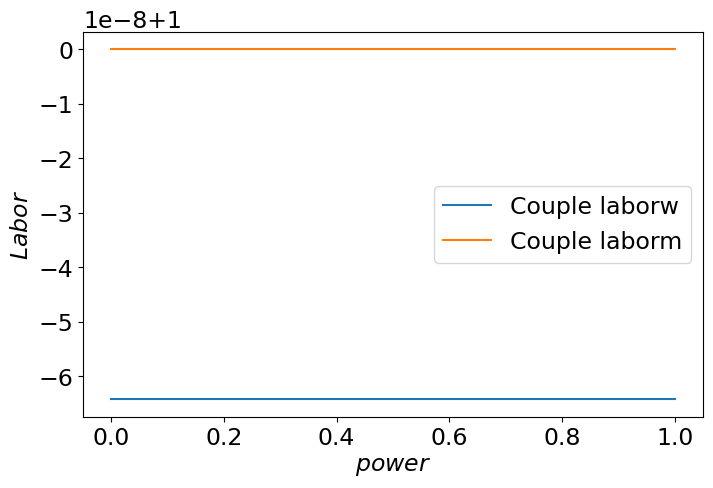

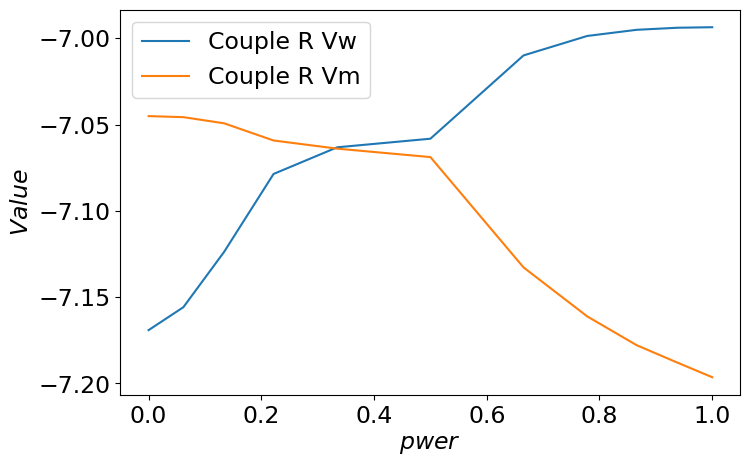

-8.904715533191293
-8.300644250891455


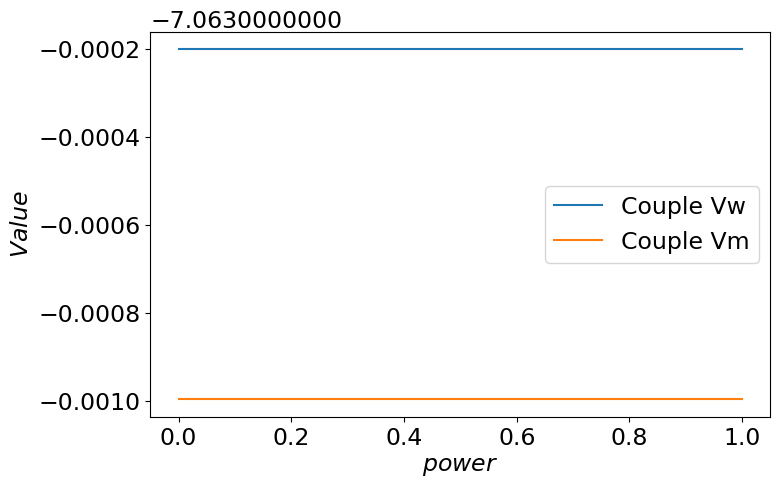

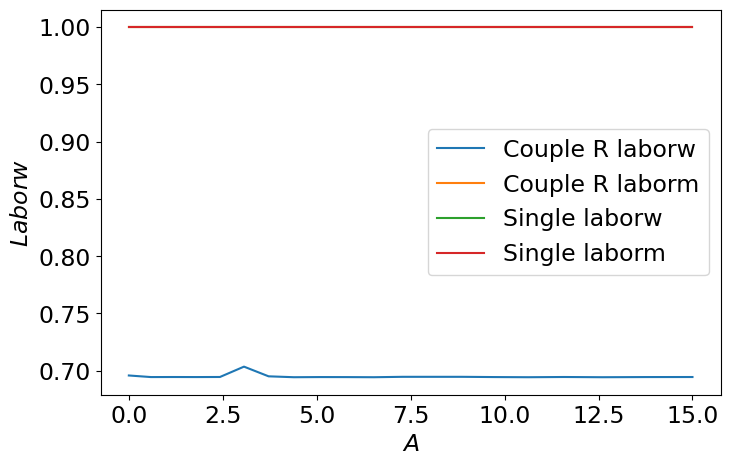

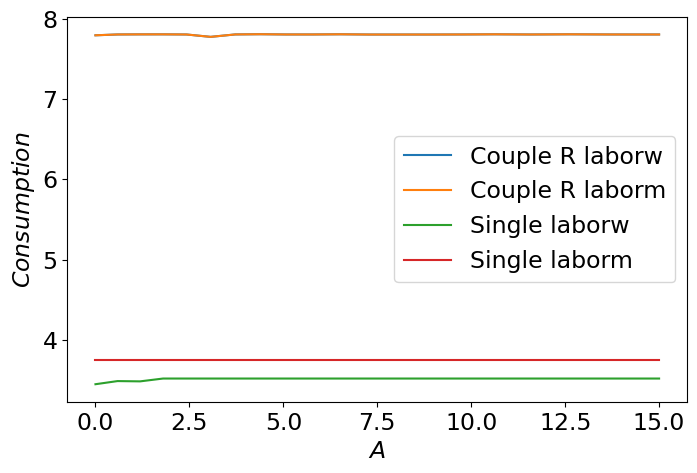

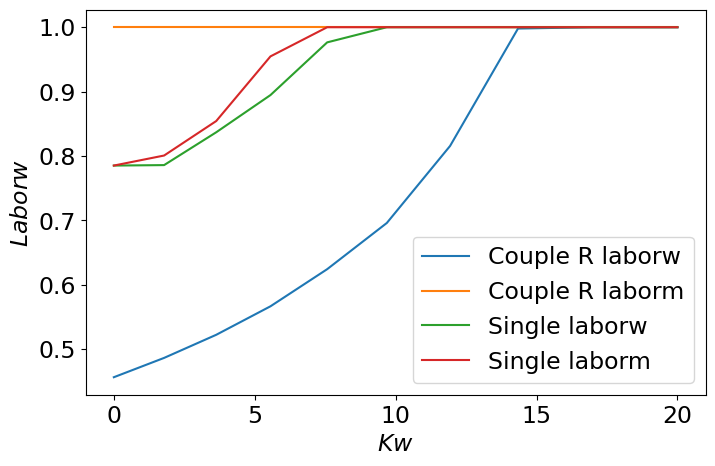

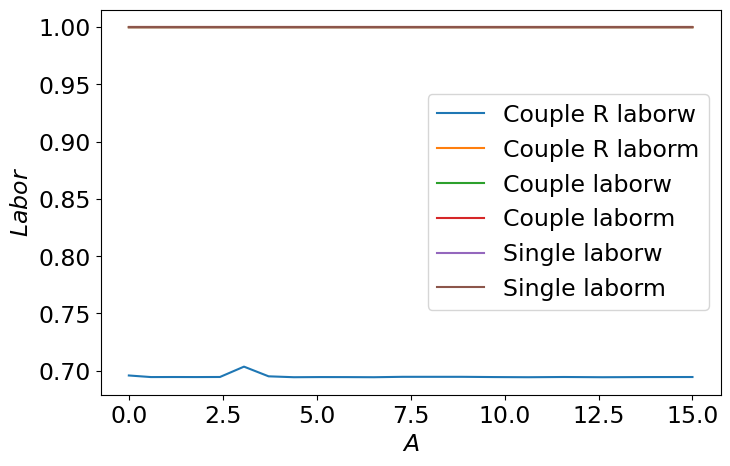

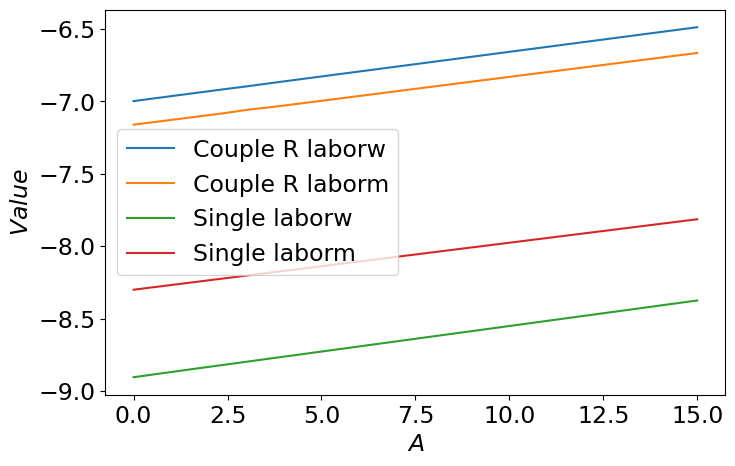

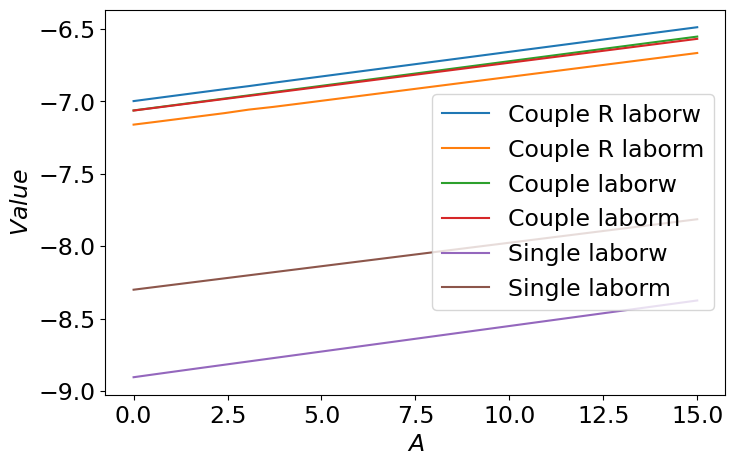

In [ ]:
i_P = 7
#DENNE BETYDER NOGET, ved 5 så ser kvinder underlige ud, den burde ikke betyde noget
#i_P = 8
i_A = 0
i_L = 5
i_t = 0
i_HKw = 5
i_HKm = 5
t = i_t


#sol = models['model 2'].sol
#par = models['model 2'].par


#print(sol.labor_w_couple[t,i_P,i_L,:,i_HKw,i_HKm])

#print(sol.labor_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm])



#print(sol.labor_w_single[t,:,i_HKm])


sol = models['model_NC'].sol
par = models['model_NC'].par
print(par.grid_love[i_L])
print(par.grid_power[i_P])
print(par.grid_K[i_HKw])
print(par.grid_K[i_HKm])

print(sol.labor_m_couple[t,:,i_L,i_A,i_HKw,i_HKm])
print(sol.labor_w_couple[t,:,i_L,i_A,i_HKw,i_HKm])


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_power,sol.labor_w_couple[t,:,i_L,i_A,i_HKw,i_HKm], label = 'Couple laborw')
ax.plot(par.grid_power,sol.labor_m_couple[t,:,i_L,i_A,i_HKw,i_HKm], label = 'Couple laborm')
ax.set_xlabel(f"$power$")
ax.set_ylabel(f"$Labor$")
plt.legend()
plt.show()

fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_power,sol.Vw_remain_couple[t,:,i_L,i_A,i_HKw,i_HKm], label = 'Couple R Vw')
ax.plot(par.grid_power,sol.Vm_remain_couple[t,:,i_L,i_A,i_HKw,i_HKm], label = 'Couple R Vm')
ax.set_xlabel(f"$pwer$")
ax.set_ylabel(f"$Value$")
plt.legend()
plt.show()

print(sol.Vw_single[t,i_A,i_HKw])
print(sol.Vm_single[t,i_A,i_HKm])
fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_power,sol.Vw_couple[t,:,i_L,i_A,i_HKw,i_HKm], label = 'Couple Vw')
ax.plot(par.grid_power,sol.Vm_couple[t,:,i_L,i_A,i_HKw,i_HKm], label = 'Couple Vm')                   
ax.set_xlabel(f"$power$")
ax.set_ylabel(f"$Value$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.labor_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.labor_m_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_A,sol.labor_w_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_A,sol.labor_m_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Laborw$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.cons_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.cons_m_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_A,sol.cons_w_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_A,sol.cons_m_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Consumption$")
plt.legend()
plt.show()




fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_K,sol.labor_w_remain_couple[t,i_P,i_L,i_A,:,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_K,sol.labor_m_remain_couple[t,i_P,i_L,i_A,:,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_K,sol.labor_w_single[t,i_A,:], label = 'Single laborw')
ax.plot(par.grid_K,sol.labor_m_single[t,i_A,:], label = 'Single laborm')                      
ax.set_xlabel(f"$Kw$")
ax.set_ylabel(f"$Laborw$")
plt.legend()
plt.show()



fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.labor_w_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.labor_m_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_A,sol.labor_w_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple laborw')
ax.plot(par.grid_A,sol.labor_m_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple laborm')
ax.plot(par.grid_A,sol.labor_w_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_A,sol.labor_m_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Labor$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.Vw_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.Vm_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_A,sol.Vw_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_A,sol.Vm_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Value$")
plt.legend()
plt.show()


fig = plt.figure(figsize=(8,5))
ax = fig.add_subplot(1,1,1)
ax.plot(par.grid_A,sol.Vw_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborw')
ax.plot(par.grid_A,sol.Vm_remain_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple R laborm')
ax.plot(par.grid_A,sol.Vw_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple laborw')
ax.plot(par.grid_A,sol.Vm_couple[t,i_P,i_L,:,i_HKw,i_HKm], label = 'Couple laborm')
ax.plot(par.grid_A,sol.Vw_single[t,:,i_HKw], label = 'Single laborw')
ax.plot(par.grid_A,sol.Vm_single[t,:,i_HKm], label = 'Single laborm')                      
ax.set_xlabel(f"$A$")
ax.set_ylabel(f"$Value$")
plt.legend()
plt.show()







# Estimate the model

In [ ]:
#Save the data 
model = models['model NC, NO_HK ']
model.sim.init_love[:] =0.1
model.sim.init_A[:] = 6.0
np.random.seed(model.par.seed)
data1 = Estimate.create_data_new(model,start_p = 9, end_p = 19, to_xl = True, name_xl = 'simulated_data_NC_NO_HK4')


In [ ]:
#Save the data 
#model = models['model LC, NO_HK ']
#model.sim.init_love[:] =0.1
#model.sim.init_A[:] = 6.0
#np.random.seed(model.par.seed)
#data1 = Estimate.create_data_new(model,start_p = 2, end_p = 19, to_xl = True, name_xl = 'simulated_data_LC_NO_HK2')


model = models['model LC, HK ']
model.sim.init_love[:] =0.3
model.sim.init_A[:] = 6.0
np.random.seed(model.par.seed)
data2 = Estimate.create_data_new(model,start_p = 2, end_p = 19, to_xl = True, name_xl = 'simulated_data_LC_HK')

#model = models['model NC, NO_HK ']
#model.sim.init_love[:] =0.1
#model.sim.init_A[:] = 6.0
#np.random.seed(model.par.seed)
#data1 = Estimate.create_data_new(model,start_p = 2, end_p = 19, to_xl = True, name_xl = 'simulated_data_NC_NO_HK2')


model = models['model NC, HK ']
model.sim.init_love[:] =0.3
model.sim.init_A[:] = 6.0
np.random.seed(model.par.seed)
data2 = Estimate.create_data_new(model,start_p = 2, end_p = 19, to_xl = True, name_xl = 'simulated_data_NC_HK')

#Save the data 
#model = models['model FC, NO_HK ']
#model.sim.init_love[:] =0.1
#model.sim.init_A[:] = 6.0
#np.random.seed(model.par.seed)
#data1 = Estimate.create_data_new(model,start_p = 2, end_p = 19, to_xl = True, name_xl = 'simulated_data_FC_NO_HK2')


model = models['model FC, HK ']
model.sim.init_love[:] =0.3
model.sim.init_A[:] = 6.0
np.random.seed(model.par.seed)
data2 = Estimate.create_data_new(model,start_p = 2, end_p = 19, to_xl = True, name_xl = 'simulated_data_FC_HK')


In [ ]:

#Estimate the model one time
data_reg = Estimate.aux_est(data2,print_reg=True)
data_reg, Wald_FC, Wald_NC = Estimate.main_est(data_reg,print_reg=True) 